In [1]:
import yank.analyze as yk
import matplotlib as mt
from matplotlib import pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
from __future__ import print_function
from numpy import dot, sqrt
from numpy.linalg import eigvalsh
#from sklearn.decomposition import PCA
import pandas as pnd
import mdtraj as md
import nglview as nv
import seaborn as sb
import numpy as np
import os as os

In [2]:
# Matplotlib options
%matplotlib inline
mt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 20, 12

## Set the path for your experiment

Path is the direcrtory where the file analysis.yaml and complex.nc files are located.

In [3]:
os.chdir ('/DATA/projects/Testing_Yank/binding/t4-lysozyme/p-xylene-explicit-output/experiments')

# Save HDF5 trajectories for each replica

Comment this part of the script once you saved your trajectories if you pretend to restart the kernel. Save trajectory files usually takes several time (depending on the number of the interations of your simulation). Be patient!

In [4]:
#n_replica= np.arange (25) #Replace this number with the total of replicas you have in your experiment
#for i in n_replica:
    #index=str(i)
    #result= yk.extract_trajectory ('complex.nc',nc_checkpoint_file='complex_checkpoint.nc', replica_index=index, start_frame=0, end_frame=-1, keep_solvent=False)
    #save_file= ('replica_trajectories/'+'replica_'+index+'.h5') #this line needs a replica_trajectories folder in 'experiments' path
    #result.save_hdf5 (save_file) #save in hdf5 format, but it can be replaced by other format depending on your interest, you can check mdtraj manual for more information

## Set the path for replica trajectory files
This folder is the location where you saved the trajectories of the replicas of your simulation.

In [5]:
os.chdir ('/DATA/projects/Testing_Yank/binding/t4-lysozyme/p-xylene-explicit-output/experiments/replica_trajectories')

# Allow to user select a replica to visualize

In [6]:
n_replica= np.arange (25)
for i in n_replica:
    index=str(input('Insert a replica number, is a int from 0 to 24:'))
    if isinstance (index, str):
            replica=('replica_'+index+'.h5')
            load_replica= md.load_hdf5 (replica)
            print (load_replica, 'number_of_replica:',index)
            break
    else: 
            print ('This is not a valid replica number, try another')
            
view= nv.show_mdtraj (load_replica) #Shows the selected replica
view.clear_representations ()
view.add_ball_and_stick (selection='MOL', color='red', aspectRatio='10')
view.add_cartoon (selection="protein")
view

Insert a replica number, is a int from 0 to 24:0
<mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells> number_of_replica: 0


NGLWidget(count=500)

# Load all replicas as new variables for analysis

In [7]:
traj={} #dictionary to create each replica as variable
n_replica= np.arange (25)
for i in n_replica:
    index=str(i)
    load=('replica_'+index+'.h5')
    trayectories=traj['{0}'.format(i)]= md.load_hdf5 (load)

In [8]:
traj

{'0': <mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells at 0x2aab29c4edd8>,
 '1': <mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells at 0x2aab29d25be0>,
 '2': <mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells at 0x2aab29dff9e8>,
 '3': <mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells at 0x2aab29edb7f0>,
 '4': <mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells at 0x2aab29c91470>,
 '5': <mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells at 0x2aab299033c8>,
 '6': <mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells at 0x2aab2990d1d0>,
 '7': <mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells at 0x2aab2a186f98>,
 '8': <mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells at 0x2aab2a261da0>,
 '9': <mdtraj.Trajectory with 500 frames, 2629 atoms, 171 residues, and unitcells 

## List of residues of the system

Is not necesary, but it could be useful

In [9]:
print ('List of residues in this experiment:',[residue for residue in traj['0'].topology.residues])

List of residues in this experiment: [MET0, ASN1, ILE2, PHE3, GLU4, MET5, LEU6, ARG7, ILE8, ASP9, GLU10, GLY11, LEU12, ARG13, LEU14, LYS15, ILE16, TYR17, LYS18, ASP19, THR20, GLU21, GLY22, TYR23, TYR24, THR25, ILE26, GLY27, ILE28, GLY29, HIS30, LEU31, LEU32, THR33, LYS34, SER35, PRO36, SER37, LEU38, ASN39, ALA40, ALA41, LYS42, SER43, GLU44, LEU45, ASP46, LYS47, ALA48, ILE49, GLY50, ARG51, ASN52, THR53, ASN54, GLY55, VAL56, ILE57, THR58, LYS59, ASP60, GLU61, ALA62, GLU63, LYS64, LEU65, PHE66, ASN67, GLN68, ASP69, VAL70, ASP71, ALA72, ALA73, VAL74, ARG75, GLY76, ILE77, LEU78, ARG79, ASN80, ALA81, LYS82, LEU83, LYS84, PRO85, VAL86, TYR87, ASP88, SER89, LEU90, ASP91, ALA92, VAL93, ARG94, ARG95, ALA96, ALA97, ALA98, ILE99, ASN100, MET101, VAL102, PHE103, GLN104, MET105, GLY106, GLU107, THR108, GLY109, VAL110, ALA111, GLY112, PHE113, THR114, ASN115, SER116, LEU117, ARG118, MET119, LEU120, GLN121, GLN122, LYS123, ARG124, TRP125, ASP126, GLU127, ALA128, ALA129, VAL130, ASN131, LEU132, ALA133, 

## Use the replica 0 trajectory to find ligand array

Again, is not necesary, but it could be useful

In [10]:
ligand=traj['0'].topology.select ('resid 162') # ID: 162 corresponds with ligand numeration in topology of the system
print(ligand) #Shows an array with number of atoms for the ligand

[2603 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616
 2617 2618 2619 2620]


# Define a variable for the ligand trayectory in each replica

In [11]:
p_xylene={} #dictionary to create p-xylene trayectories for each replica
n_replica= np.arange (25)
for i in n_replica:
    index=str(i)
    load=('replica_'+index+'.h5')
    trayectories=p_xylene['{0}'.format(i)]= md.load_hdf5 (load, atom_indices=[2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620])

In [12]:
p_xylene

{'0': <mdtraj.Trajectory with 500 frames, 18 atoms, 1 residues, and unitcells at 0x2aab2bcd9320>,
 '1': <mdtraj.Trajectory with 500 frames, 18 atoms, 1 residues, and unitcells at 0x2aab30185710>,
 '2': <mdtraj.Trajectory with 500 frames, 18 atoms, 1 residues, and unitcells at 0x2aab3025f9b0>,
 '3': <mdtraj.Trajectory with 500 frames, 18 atoms, 1 residues, and unitcells at 0x2aab3033cc50>,
 '4': <mdtraj.Trajectory with 500 frames, 18 atoms, 1 residues, and unitcells at 0x2aab30416ef0>,
 '5': <mdtraj.Trajectory with 500 frames, 18 atoms, 1 residues, and unitcells at 0x2aab300041d0>,
 '6': <mdtraj.Trajectory with 500 frames, 18 atoms, 1 residues, and unitcells at 0x2aab2be79898>,
 '7': <mdtraj.Trajectory with 500 frames, 18 atoms, 1 residues, and unitcells at 0x2aab306ad710>,
 '8': <mdtraj.Trajectory with 500 frames, 18 atoms, 1 residues, and unitcells at 0x2aab307889b0>,
 '9': <mdtraj.Trajectory with 500 frames, 18 atoms, 1 residues, and unitcells at 0x2aab301b3b38>,
 '10': <mdtraj.Traje

## Create a clustering plot for two replicas

replica 1 and 25

In [13]:
distances = np.empty ((p_xylene['0'].n_frames, p_xylene['0'].n_frames))
for i in range(p_xylene['0'].n_frames):
    distances[i] = md.rmsd(p_xylene['0'],p_xylene['0'], i)
print('Max pairwise rmsd: %f nm' % np.max(distances))

Max pairwise rmsd: 0.121701 nm


In [14]:
reduced_distances = squareform(distances, checks=False)
linkage = scipy.cluster.hierarchy.linkage(reduced_distances, method='average')

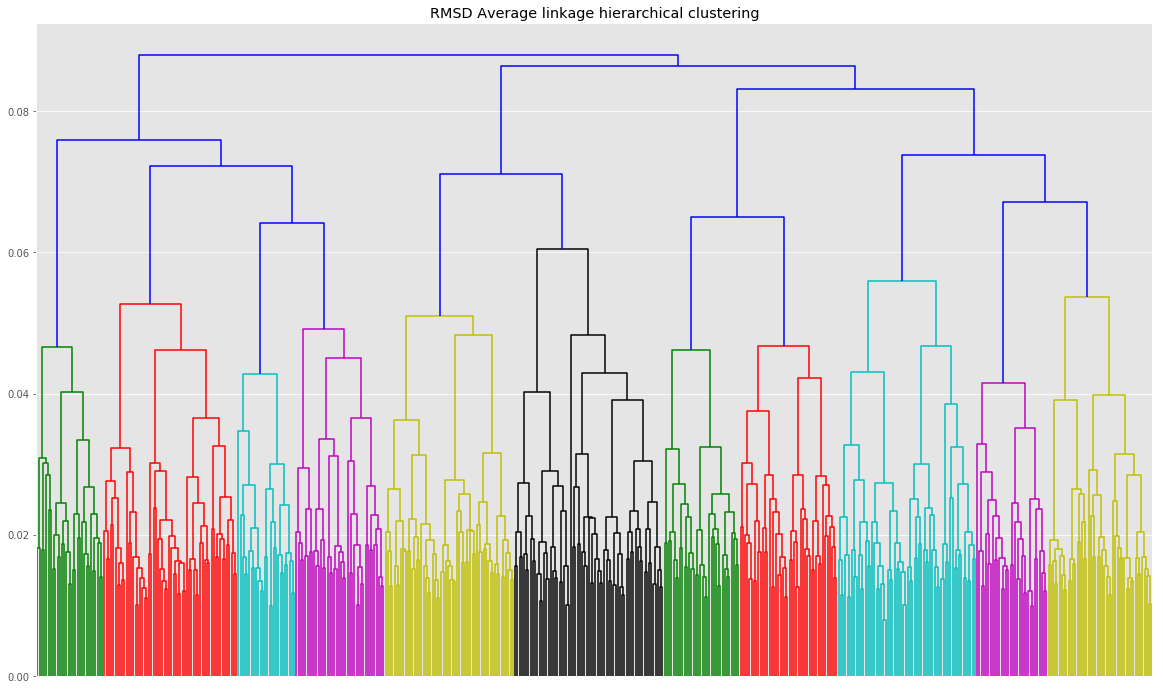

In [15]:
plt.title('RMSD Average linkage hierarchical clustering')
plot = scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')

/opt/apps/conda/intel-2018.1.163_miniconda/envs/yank/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: in rmsd(), precentered is ignored when atom_indices != None
  """Entry point for launching an IPython kernel.


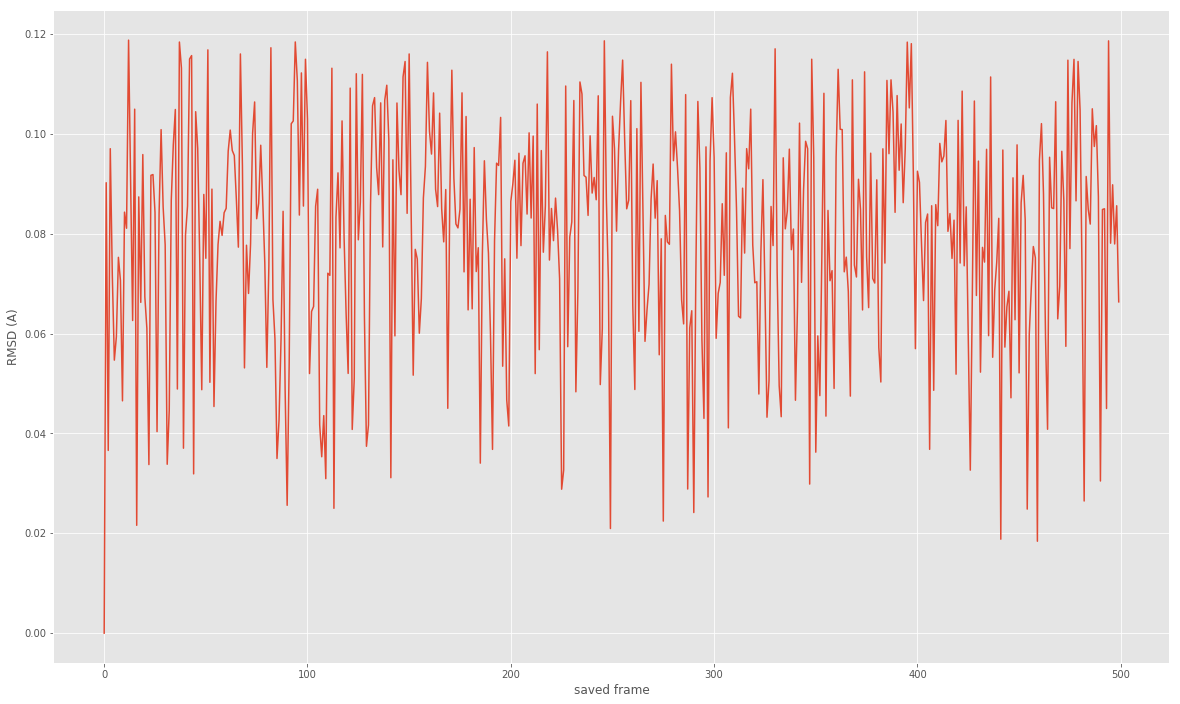

In [16]:
rmsd=md.rmsd (p_xylene['0'],p_xylene['0'],precentered=True)
plt.plot(rmsd)
plt.xlabel("saved frame")
plt.ylabel("RMSD (A)")
plt.show()

# Calculating gemetric center for p-xylene

Lets compute all pairwise rmsds between conformations.

In [17]:
atom_indices = [a.index for a in p_xylene['0'].topology.atoms if a.element.symbol != 'H']
distances = np.empty((p_xylene['0'].n_frames, p_xylene['0'].n_frames))
for i in range(p_xylene['0'].n_frames):
    distances[i] = md.rmsd(p_xylene['0'], p_xylene['0'], i, atom_indices=atom_indices)

The algorithim we're going to use is relatively simple:

    Compute all of the pairwise RMSDs between the conformations. This is O(N^2), so it's not going to scale extremely well to large datasets.
    Transform these distances into similarity scores. Our similarities will calculated as
    sij=e−β⋅dij/dscale

where sij is the pairwise similarity, dij is the pairwise distance, and dscale is the standard deviation of the values of d
, to make the computation scale invariant.
Then, we define the centroid as

argmaxi∑jsij

Using β=1
, this is implemented with the following code:

In [18]:
beta = 1
index = np.exp(-beta*distances / distances.std()).sum(axis=1).argmax()
print(index)

200


In [19]:
centroid = p_xylene['0'][index]
xyz=centroid.xyz
print (xyz)

[[[ 0.05809236  0.06210177  0.11295407]
  [ 0.13490582  0.03353708  0.00207583]
  [-0.13609791 -0.03508193  0.00458781]
  [-0.05735874 -0.06387264 -0.10613424]
  [-0.07929587  0.03119557  0.11630719]
  [ 0.07893181 -0.02683217 -0.11346013]
  [-0.1641612   0.06611507  0.23313779]
  [ 0.16545749 -0.06654102 -0.23365146]
  [ 0.09976006  0.11806219  0.1961779 ]
  [ 0.2403543   0.05893605 -0.00335153]
  [-0.23973346 -0.06732828  0.00830332]
  [-0.09982705 -0.10798103 -0.1958273 ]
  [-0.22540212  0.14891976  0.19536227]
  [-0.22190976 -0.02510697  0.25257295]
  [-0.11011076  0.09148019  0.3251664 ]
  [ 0.12706566 -0.01192648 -0.32069975]
  [ 0.26806784 -0.03226454 -0.21547753]
  [ 0.16126156 -0.17341262 -0.2580436 ]]]


In [20]:
distances = np.empty ((p_xylene['0'].n_frames, p_xylene['0'].n_frames))
for i in range(centroid.n_frames):
    distances[i] = md.rmsd(p_xylene['0'],p_xylene['0'], i)
print('Max pairwise rmsd: %f nm' % np.max(distances))

Max pairwise rmsd: 0.118743 nm


In [26]:
reduced_distances = squareform(distances, checks=False)
linkage = scipy.cluster.hierarchy.linkage(reduced_distances, metric='euclidean')

ValueError: Linkage 'Z' contains negative distances.

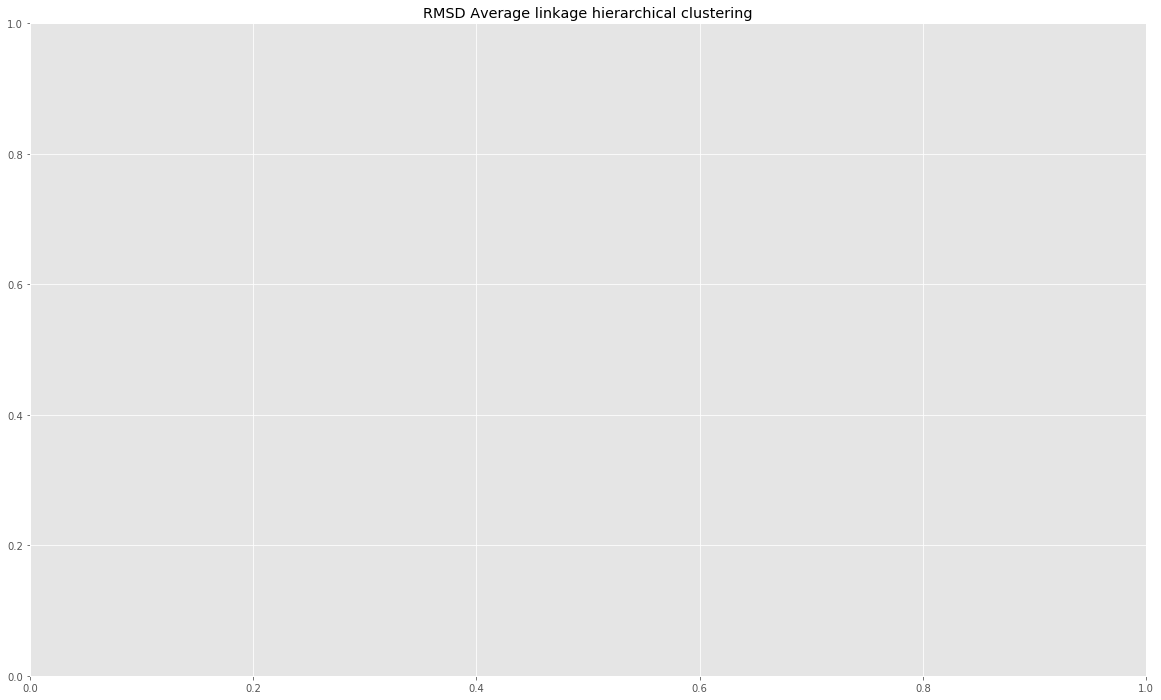

In [27]:
plt.title('RMSD Average linkage hierarchical clustering')
plot = scipy.cluster.hierarchy.dendrogram (linkage, no_labels=True, count_sort='descendent')

In [ ]:
plt.plot(centroid.xyz)
plt.xlabel("saved frame")
plt.ylabel("RMSD (A)")
plt.show()

In [ ]:
fw=p_xylene['0'].xyz
print (fw)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter (fw, c='b', marker='o')
ax.set_xlabel ('x axis')
ax.set_ylabel ('y axis')
ax.set_zlabel ('z axis')